<a href="https://colab.research.google.com/github/rybak97/SR_cartoon/blob/main/FSRCNN_Tom%26Jerry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt

import math

import cv2 as cv
import numpy as np

import os

import gc 


Szczytowy stosunek sygnału do szumu, rzadziej stosunek sygnału szczytowego do szumu (PSNR, ang. peak signal-to-noise ratio) – stosunek maksymalnej mocy sygnału do mocy szumu zakłócającego ten sygnał. Ze względu na szeroki zakres wartości PSNR wyrażany jest w decybelach.

PSNR jest przybliżeniem ludzkiej percepcji jakości rekonstrukcji.

W przypadku braku szumu oba obrazy są identyczne, a zatem MSE wynosi zero. W tym przypadku PSNR jest nieskończony

In [29]:
def psnr(target, ref):
         
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(1. / rmse)

SSIM służy do pomiaru podobieństwa między dwoma obrazami. Pomiar jakości obrazu opiera się na pozbawionym zniekształceń obrazie jako wzorcu. Wskaźnik podobieństwa strukturalnego (SSIM) wyodrębnia 3 kluczowe cechy obrazu:
jasność, kontrast, struktura.

In [30]:
def ssim(img1, img2):
    C1 = (0.01 * 1.0)**2.0
    C2 = (0.03 * 1.0)**2.0
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    kernel = cv.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())
    mu1 = cv.filter2D(img1, -1, window)[5:-5, 5:-5] # valid
    mu2 = cv.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                              (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [31]:
def calculate_ssim(img1, img2):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
model2 = keras.models.load_model('/content/FSRCNN_Tom&Jerry_20.h5')

In [34]:
img_GT = cv.imread('/content/TOM_AND_JERRY25357.jpg')

In [35]:
img_GT_RGB = cv.cvtColor(img_GT, cv.COLOR_BGR2RGB)
img_GT = img_GT_RGB / 255.
img_GT = cv.resize(img_GT,(480,360))


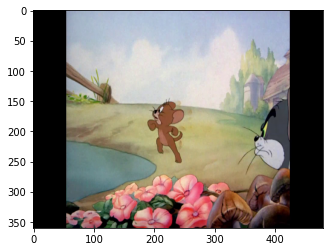

In [36]:
plt.imshow(img_GT)

plt.show()

In [37]:
img_LR = cv.resize(img_GT_RGB, (80,60),interpolation=cv.INTER_LINEAR)
img_LR_255 = cv.resize(img_LR,(480,360), interpolation=cv.INTER_NEAREST) 
img_LR = img_LR_255 / 255.

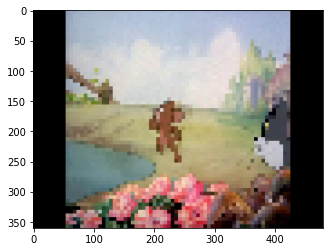

In [38]:
plt.imshow(img_LR)

plt.show()

In [39]:
img_LR.shape

(360, 480, 3)

In [40]:
psnr(img_LR,img_GT)

23.197867724738384

In [41]:
psnr1 = tf.image.psnr(img_LR, img_GT, max_val=1)
print(psnr1)

tf.Tensor(23.197866, shape=(), dtype=float32)


SSIM

In [44]:
img_GT = cv.cvtColor(img_GT_RGB, cv.COLOR_RGB2GRAY)
img_LR = cv.cvtColor(img_LR_255, cv.COLOR_RGB2GRAY)

img_GT = cv.resize(img_GT,(480,360)) 

img_LR = img_LR / 255.
img_GT = img_GT / 255.


In [45]:
img_LR_own = np.reshape(img_LR,(480,360,1))
img_GT_own = np.reshape(img_GT,(480,360,1))

In [46]:
img_GT_own.shape

(480, 360, 1)

In [47]:
z = calculate_ssim(img_LR_own,img_GT_own)
print(z)

0.96256095


In [48]:
img_LR = tf.reshape(img_LR, [480,360,1,1])

img_GT = tf.reshape(img_GT, [480,360,1,1])

img_LR = tf.image.convert_image_dtype(img_LR, tf.float32)
img_GT = tf.image.convert_image_dtype(img_GT, tf.float32)

ssim1 = tf.image.ssim_multiscale(img_LR, img_GT, max_val=1, filter_size=1,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
print(np.mean(ssim1))

0.99854314


================


In [123]:
img_GT = cv.imread('/content/TOM_AND_JERRY25357.jpg')

In [124]:
img_GT = cv.cvtColor(img_GT, cv.COLOR_BGR2RGB)
img_GT = img_GT / 255.

img_GT = cv.resize(img_GT,(480,360))

In [125]:
img_LR = cv.resize(img_GT, (80,60),interpolation=cv.INTER_LINEAR)
img_LR = cv.resize(img_LR,(480,360), interpolation=cv.INTER_NEAREST) 

In [126]:
img_LR = np.reshape(img_LR,(1,360,480,3))

img_SR = model2.predict(img_LR)

In [127]:
img_SR

array([[[[-0.00481783,  0.00349356,  0.00055627],
         [-0.00398183,  0.00781349,  0.00094184],
         [-0.00540645,  0.00578065,  0.00238827],
         ...,
         [ 0.00367396, -0.00174656, -0.00588474],
         [ 0.00436667, -0.00243474, -0.00657313],
         [ 0.00092535, -0.00483552, -0.00931384]],

        [[-0.00500776,  0.00585168,  0.00341486],
         [-0.00172171,  0.01147238,  0.00378233],
         [-0.00185225,  0.01092062,  0.00713537],
         ...,
         [ 0.00701559,  0.00147566, -0.0027866 ],
         [ 0.00797788,  0.00022559, -0.00568856],
         [ 0.00423933, -0.00470197, -0.00982546]],

        [[-0.00364136,  0.00772373,  0.0035186 ],
         [-0.00012311,  0.01285111,  0.00503163],
         [ 0.00022924,  0.01279668,  0.00984534],
         ...,
         [ 0.00843895,  0.00467172,  0.00030018],
         [ 0.00954375,  0.00272519, -0.00358519],
         [ 0.00459912, -0.00203656, -0.00909751]],

        ...,

        [[ 0.00432968,  0.00484412,  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


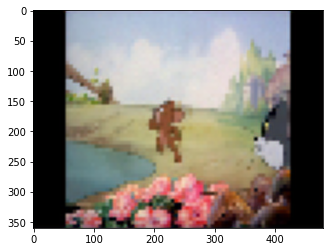

In [128]:
plt.imshow(img_SR[0])

In [129]:
psnr(img_SR,img_GT)

25.334381030882035

In [130]:
psnr1 = tf.image.psnr(img_SR, img_GT, max_val=1)
print(psnr1)

tf.Tensor([25.334381], shape=(1,), dtype=float32)


SSIM

In [131]:
img_SR.shape

(1, 360, 480, 3)

In [132]:
img_SR = np.reshape(img_SR,(480,360,3))

In [133]:
img_GT = cv.cvtColor(img_GT_RGB, cv.COLOR_RGB2GRAY)
img_SR = cv.cvtColor(img_SR, cv.COLOR_RGB2GRAY)


img_GT = img_GT / 255.

In [134]:
img_SR[img_SR < 0] = 0

In [135]:
img_SR

array([[6.7360548e-04, 3.5033249e-03, 2.0489770e-03, ..., 6.9655102e-01,
        6.9515043e-01, 6.9390929e-01],
       [6.9255227e-01, 6.9170839e-01, 6.9002062e-01, ..., 7.4902886e-01,
        7.4808985e-01, 7.4600458e-01],
       [7.4378639e-01, 7.4177408e-01, 7.3954749e-01, ..., 7.0270586e-01,
        7.0041198e-01, 7.0027375e-01],
       ...,
       [1.7920086e-01, 1.9862451e-01, 2.0595464e-01, ..., 1.1295663e-02,
        2.1669760e-02, 3.7784707e-02],
       [7.7040479e-02, 1.0618079e-01, 1.1633293e-01, ..., 6.9421463e-02,
        8.9500353e-02, 1.0496897e-01],
       [1.4501636e-01, 1.8644924e-01, 2.1567863e-01, ..., 1.4264275e-02,
        1.2382900e-02, 8.9582801e-03]], dtype=float32)

In [137]:
img_SR_own = np.reshape(img_SR,(480,360,1))
img_GT = cv.resize(img_GT,(480,360))
img_GT_own = np.reshape(img_GT,(480,360,1))

In [138]:
z = calculate_ssim(img_SR_own,img_GT_own)
print(z)

0.9761644


In [140]:
img_SR = tf.reshape(img_SR_own, [480,360,1,1])

img_GT = tf.reshape(img_GT_own, [480,360,1,1])

img_SR = tf.image.convert_image_dtype(img_SR, tf.float64)
img_GT = tf.image.convert_image_dtype(img_GT, tf.float64)

ssim1 = tf.image.ssim_multiscale(img_SR,img_GT, max_val=1, filter_size=1,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
print(np.mean(ssim1))

0.99681574
